##### Data Import

In [1]:
# %%capture
# !pip install scikit-learn
# !pip install fancyimpute
# !pip install xgboost
# !pip install graphviz
# !pip install GPyOpt

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import graphviz
from fancyimpute import IterativeImputer
import shap
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from xgboost import XGBClassifier
from xgboost import plot_importance
from fancyimpute import IterativeImputer
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-uk2618qx because the default path (/gpfs/home/pandik01/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
df = pd.read_csv('/gpfs/data/proteomics/projects/pandik01/cleaned_data_09_08_2021.csv')

In [4]:
#changing cols with mixed dtypes to single dtype 
df.astype({df.columns[10]:'str', df.columns[11]:'str', df.columns[38]:'str'})

df.shape

(31580, 415)

In [5]:
col_names = ['Patient.Age', 'AGE_AT_DELIVERY', 'Gravida', 'Para', 'Term', 'Preterm', 'Abortions', 
             'Living.at.Delivery.Ct', 'RACE_White', 'RACE_African_American', 'RACE_Asian', 
             'RACE_Native_Hawaiian_or_Other_Pacific_Islander', 'RACE_Other_Race', 
             'ETHNICITY_Not_of_Spanish_Hispanic_Origin','ETHNICITY_Patient_Refused', 
             'ETHNICITY_Unknown', 'R.BMI', 'GA_IN_DAYS', 'Insulin', 'Insulin.NPH', 'Insulin.aspart', 'Insulin.detemir',
             'Insulin.glargine','Insulin.lispro','Insulin.regular', 'Oral.glycemic','GLUCOSE.CHALLENGE..PREGNANCY',
             'GLUCOSE.TOLERANCE.TEST.1.HOUR','GLUCOSE.TOLERANCE.TEST.2.HOUR','GLUCOSE.TOLERANCE.TEST.3.HOUR',
            'HEMOGLOBIN_FIRST_TRIMESTER','HEMOGLOBIN_SECOND_TRIMESTER','HEMOGLOBIN_THIRD_TRIMESTER',
             'PMH_Macrosomia_or_LGA', 'Macrosomia','IUGR','IUFD_or_demise','Grand_multip','Apgar.1','Apgar.5',
             'Apgar.10','Baby.Sex']
df = df[col_names]
        

In [6]:
#remaining features with NaN values
df.columns[df.isna().sum()!=0]

Index(['Patient.Age', 'AGE_AT_DELIVERY', 'Gravida', 'Para', 'Term', 'Preterm',
       'Abortions', 'Living.at.Delivery.Ct', 'R.BMI', 'GA_IN_DAYS',
       'GLUCOSE.CHALLENGE..PREGNANCY', 'GLUCOSE.TOLERANCE.TEST.1.HOUR',
       'GLUCOSE.TOLERANCE.TEST.2.HOUR', 'GLUCOSE.TOLERANCE.TEST.3.HOUR',
       'HEMOGLOBIN_FIRST_TRIMESTER', 'HEMOGLOBIN_SECOND_TRIMESTER',
       'HEMOGLOBIN_THIRD_TRIMESTER', 'Apgar.1', 'Apgar.5', 'Apgar.10',
       'Baby.Sex'],
      dtype='object')

In [7]:
#combining 'Patient.Age' and 'AGE_AT_DELIVERY' columns to fill NaN

#converting dtype to int for both columns
df['Patient.Age'] = df['Patient.Age'].fillna(0).astype(int)
df['AGE_AT_DELIVERY'] = df['AGE_AT_DELIVERY'].fillna(0).astype(int)

#replacing NaN values in 'Patient.Age' using 'AGE_AT_DELIVERY' values
df.iloc[:,:1] = df['AGE_AT_DELIVERY'].combine_first(df['Patient.Age'])

#dropping one of two age descriptors
df = df.drop(columns = 'Patient.Age') #redundant

#confirming no NaN values in Patient.Age
df[df['AGE_AT_DELIVERY'].isnull()]

,AGE_AT_DELIVERY,Gravida,Para,Term,Preterm,Abortions,Living.at.Delivery.Ct,RACE_White,RACE_African_American,RACE_Asian,...,HEMOGLOBIN_THIRD_TRIMESTER,PMH_Macrosomia_or_LGA,Macrosomia,IUGR,IUFD_or_demise,Grand_multip,Apgar.1,Apgar.5,Apgar.10,Baby.Sex


In [8]:
## remaining features with NaN values
# df.isna().sum()

In [9]:
#dropping all columns where most entries are NaN (>50%)
df = df.dropna(axis=1, thresh = 15000)

#remaining features with NaN values
df.shape

(31580, 34)

# Data Preprocessing

In [10]:
#converting all missing values to zeroes
df = df.fillna(0)

#replacing spaces in df with underscores
df.replace(' ', '_', regex=True, inplace=True)

#replacing spaces and periods in column names with underscores (necessary for plotting tree later on)
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('.', '_')

In [11]:
#sorting by incidence of macrosomia
df = df.sort_values(by=['Macrosomia'])

#resetting index
df = df.reset_index()

#subsampling top 250 (No Macrosomia) and bottom 248 (Macrosomia)
df_no_mac = df.iloc[0:250,:]
df_mac = df.iloc[-249:-1,:]

#verifying counts of each label category
print(df_no_mac['Macrosomia'].value_counts())
print(df_mac['Macrosomia'].value_counts())

0    250
Name: Macrosomia, dtype: int64
1    248
Name: Macrosomia, dtype: int64


In [12]:
#concatenating dfs
df = pd.concat([df_no_mac, df_mac])

#removing index column
df = df.drop('index', axis = 1)

# Splitting Data

In [13]:
#creating featuers variable by removing Macrosomia column
X = df.drop('Macrosomia', axis = 1).copy()

#creating labels variable using Macrosomia column
y = pd.DataFrame(df['Macrosomia'])

In [14]:
#splitting data into train/validation/test (60/20/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle = True, stratify = y_train)

In [15]:
X_train.shape

(298, 33)

In [16]:
X_valid.shape

(100, 33)

In [17]:
X_test.shape

(100, 33)

In [18]:
#verifying class balance is maintained across datasets as bar graph

def plot_counts(df, title):
    Normal, Macrosomia = df['Macrosomia'].value_counts()
    plt.figure(figsize=(4,4))
    sns.countplot('Macrosomia', data=df, palette="Paired")
    plt.title(title)
    plt.annotate(Normal, xy=(-0.2, 250), xytext=(-0.1, 280), size=12, color='black')
    plt.annotate(Macrosomia, xy=(-0.2, 250), xytext=(0.9, 280), size=12, color='black')
    plt.show()

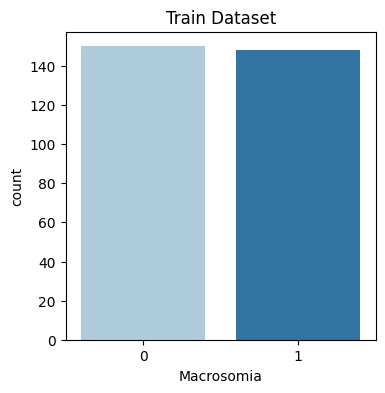

In [19]:
plot_counts(y_train, 'Train Dataset')

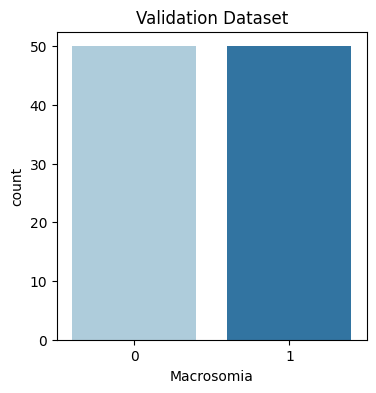

In [20]:
plot_counts(y_valid, 'Validation Dataset')

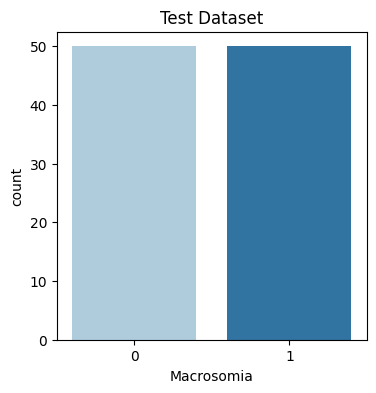

In [21]:
plot_counts(y_test, 'Test Dataset')

# Model Building

## Scenario 9:

### Imputation method: XGB Missing parameter (XGB MP)
### Class imbalance: No (No CI)
### Feature selection: No (No FS)
### Optimization: Grid search (GS)

In [22]:
#fitting model to train set
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42, scale_pos_weight = 1, missing = 0)
clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric=['aucpr', 'error'],
           eval_set=[(X_train, y_train), (X_valid, y_valid)])

[0]	validation_0-aucpr:0.87393	validation_0-error:0.19128	validation_1-aucpr:0.60636	validation_1-error:0.44000
[1]	validation_0-aucpr:0.90173	validation_0-error:0.15101	validation_1-aucpr:0.62414	validation_1-error:0.41000
[2]	validation_0-aucpr:0.93944	validation_0-error:0.12752	validation_1-aucpr:0.73341	validation_1-error:0.39000
[3]	validation_0-aucpr:0.95756	validation_0-error:0.10738	validation_1-aucpr:0.70111	validation_1-error:0.34000
[4]	validation_0-aucpr:0.96768	validation_0-error:0.09732	validation_1-aucpr:0.72505	validation_1-error:0.31000
[5]	validation_0-aucpr:0.97134	validation_0-error:0.09396	validation_1-aucpr:0.72686	validation_1-error:0.30000
[6]	validation_0-aucpr:0.98131	validation_0-error:0.08389	validation_1-aucpr:0.72483	validation_1-error:0.33000
[7]	validation_0-aucpr:0.98341	validation_0-error:0.07047	validation_1-aucpr:0.72744	validation_1-error:0.35000
[8]	validation_0-aucpr:0.98526	validation_0-error:0.05369	validation_1-aucpr:0.72308	validation_1-error:

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=0, monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

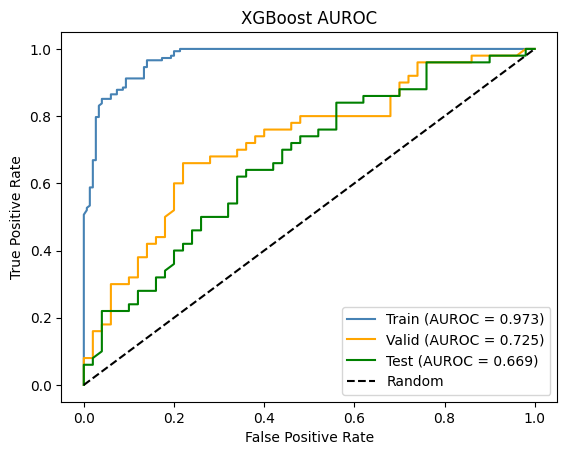

In [23]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = clf_xgb.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = clf_xgb.predict_proba(X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = clf_xgb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

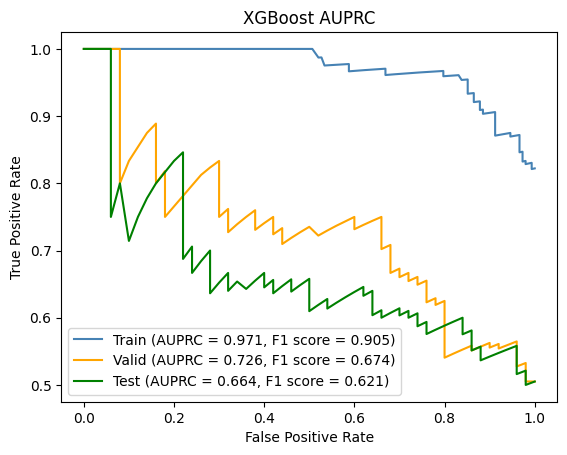

In [24]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = clf_xgb.predict_proba(X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = clf_xgb.predict_proba(X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = clf_xgb.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

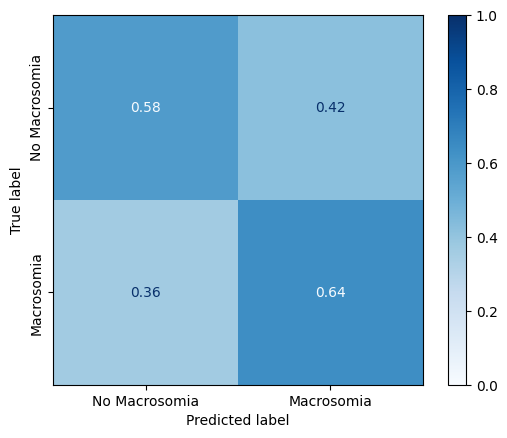

In [25]:
#plotting confusion matrix
predictions = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf_xgb.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        clf_xgb,
        X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

In [43]:
# #optimizating using Grid Search

# #ROUND 1

# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.5, 1],
#     'reg_lambda': [0, 5, 10], 
#     'n_estimators': [50, 70, 90],
#     'min_child_weight': [5, 6, 7]
# }

In [47]:
#ROUND 2

param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.05],
    'gamma': [1, 2, 3],
    'reg_lambda': [10, 11, 12], 
    'n_estimators': [70],
    'min_child_weight': [3, 4, 5]
}

In [48]:
#grid searching for best hyperparameters
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5,
                                scale_pos_weight = 1,
                                missing = 0),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=2,
    n_jobs = 10,
    cv = 5
)

In [49]:
#printing optimal parameters to readjust for actual training
optimal_params.fit(X_train, 
                  y_train,
                  early_stopping_rounds=10,
                  eval_metric='auc',
                  eval_set=[(X_valid, y_valid)],
                  verbose=True)
print(optimal_params.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[0]	validation_0-auc:0.63800
[1]	validation_0-auc:0.71980
[2]	validation_0-auc:0.71180
[3]	validation_0-auc:0.72520
[4]	validation_0-auc:0.73480
[5]	validation_0-auc:0.73820
[6]	validation_0-auc:0.72620
[7]	validation_0-auc:0.72620
[8]	validation_0-auc:0.72940
[9]	validation_0-auc:0.72640
[10]	validation_0-auc:0.72680
[11]	validation_0-auc:0.72920
[12]	validation_0-auc:0.72880
[13]	validation_0-auc:0.73220
[14]	validation_0-auc:0.73180
[15]	validation_0-auc:0.73060
{'gamma': 1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 70, 'reg_lambda': 10}


In [50]:
#fitting model to tuned hyperparameters
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                            seed=42,
                            gamma=1,
                            learning_rate=0.05,
                            max_depth=5,
                            min_child_weight = 5,
                            n_estimators = 70,
                            reg_lambda=10,
                            scale_pos_weight=1, #sum(negative instances) / sum(positive instances)
                            subsample=0.9,
                            colsample_bytree=0.5,
                            missing = 0)

clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='auc',
           eval_set=[(X_train, y_train), (X_valid, y_valid), (X_test, y_test)])

[0]	validation_0-auc:0.68014	validation_1-auc:0.63800	validation_2-auc:0.67600
[1]	validation_0-auc:0.75306	validation_1-auc:0.71980	validation_2-auc:0.80960
[2]	validation_0-auc:0.75827	validation_1-auc:0.71180	validation_2-auc:0.81080
[3]	validation_0-auc:0.75941	validation_1-auc:0.72520	validation_2-auc:0.80080
[4]	validation_0-auc:0.78216	validation_1-auc:0.73480	validation_2-auc:0.79080
[5]	validation_0-auc:0.77842	validation_1-auc:0.73820	validation_2-auc:0.78840
[6]	validation_0-auc:0.78502	validation_1-auc:0.72620	validation_2-auc:0.78860
[7]	validation_0-auc:0.78730	validation_1-auc:0.72620	validation_2-auc:0.78940
[8]	validation_0-auc:0.78563	validation_1-auc:0.72940	validation_2-auc:0.78900
[9]	validation_0-auc:0.78890	validation_1-auc:0.72640	validation_2-auc:0.78900
[10]	validation_0-auc:0.78892	validation_1-auc:0.72680	validation_2-auc:0.79140
[11]	validation_0-auc:0.79590	validation_1-auc:0.72920	validation_2-auc:0.79160


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=5,
              missing=0, monotone_constraints='()', n_estimators=70, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=10, ...)

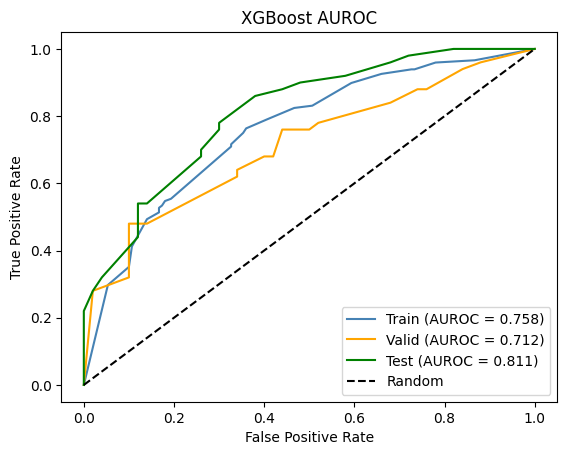

In [51]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = clf_xgb.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = clf_xgb.predict_proba(X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = clf_xgb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

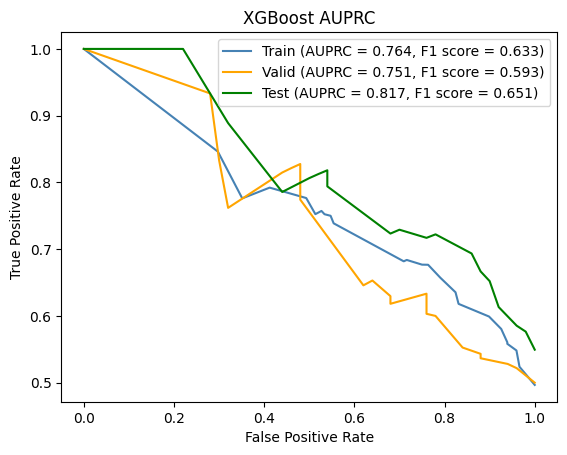

In [52]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = clf_xgb.predict_proba(X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = clf_xgb.predict_proba(X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = clf_xgb.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

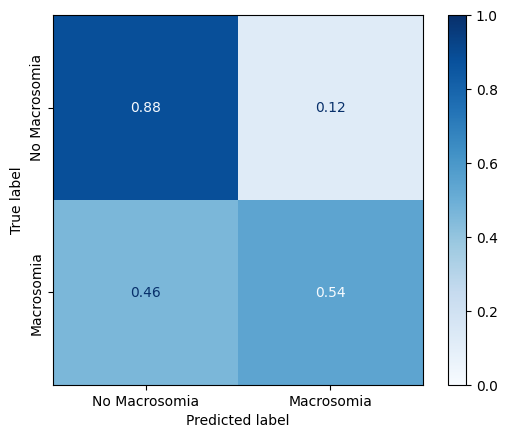

In [53]:
#plotting confusion matrix
predictions = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf_xgb.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        clf_xgb,
        X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

weight:  {'AGE_AT_DELIVERY': 9.0, 'Gravida': 1.0, 'Para': 3.0, 'Term': 7.0, 'Living_at_Delivery_Ct': 4.0, 'R_BMI': 11.0, 'GA_IN_DAYS': 8.0, 'HEMOGLOBIN_THIRD_TRIMESTER': 1.0, 'Apgar_1': 1.0, 'Baby_Sex': 1.0}
gain:  {'AGE_AT_DELIVERY': 3.266270160675049, 'Gravida': 1.107485294342041, 'Para': 6.375593662261963, 'Term': 4.450407981872559, 'Living_at_Delivery_Ct': 4.358914375305176, 'R_BMI': 14.192046165466309, 'GA_IN_DAYS': 2.9685959815979004, 'HEMOGLOBIN_THIRD_TRIMESTER': 2.061755657196045, 'Apgar_1': 1.2450039386749268, 'Baby_Sex': 4.6221022605896}
cover:  {'AGE_AT_DELIVERY': 31.01224136352539, 'Gravida': 32.75, 'Para': 58.03684616088867, 'Term': 40.02602005004883, 'Living_at_Delivery_Ct': 40.83200454711914, 'R_BMI': 55.9996452331543, 'GA_IN_DAYS': 28.583847045898438, 'HEMOGLOBIN_THIRD_TRIMESTER': 30.434724807739258, 'Apgar_1': 10.5, 'Baby_Sex': 29.455638885498047}
total_gain:  {'AGE_AT_DELIVERY': 29.39643096923828, 'Gravida': 1.107485294342041, 'Para': 19.126781463623047, 'Term': 31.15

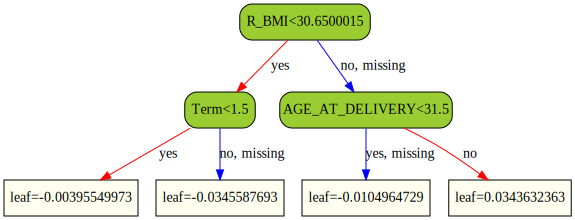

In [54]:
#plotting tree
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#9ACD32'     
                }  

leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#FFFFF0'     
                }  

xgb.to_graphviz(clf_xgb, num_trees=1
                , size='10,10',
               condition_node_params=node_params,
               leaf_node_params=leaf_params)

#add .render() at the end to save as pdf

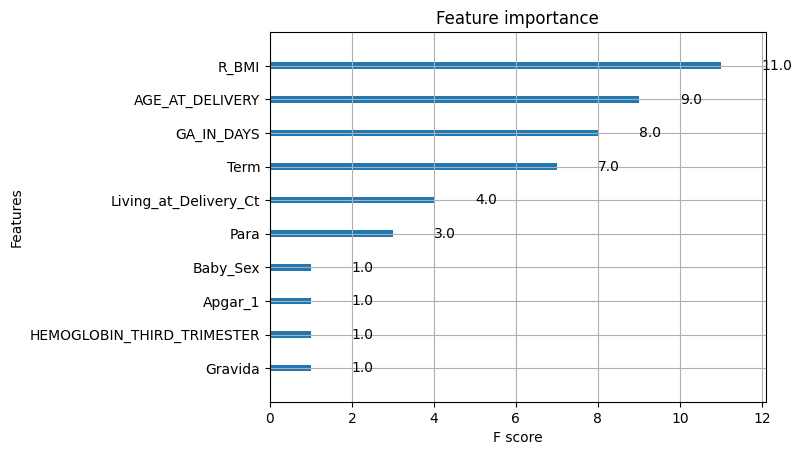

In [55]:
#plotting overall feature importance
plot_importance(clf_xgb)
plt.show()

In [56]:
#plotting individual feature importance
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.initjs()
shap.plots.force(shap_values[0])

## Scenario 10:

### Imputation method: XGB Missing parameter (XGB MP)
### Class imbalance: No (No CI)
### Feature selection: No (No FS)
### Optimization: Bayesian (Bay.)

In [57]:
#Converting the dataframe into XGBoost’s Dmatrix object
dtrain = xgb.DMatrix(X_train, label=y_train)

#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, n_estimators, learning_rate, reg_lambda, min_child_weight):
    params = {'max_depth': int(max_depth),
              'learning_rate':learning_rate,
              'gamma': gamma,
              'reg_lambda': reg_lambda,
              'n_estimators': int(n_estimators),
              'min_child_weight': min_child_weight,
              'subsample': 0.9,
              'eta': 0.1,
              
              'eval_metric': 'rmse'}
    #Cross validating with the specified parameters in 5 folds and 70 iterations
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                            'learning_rate': (0, 1),
                                            'gamma': (0, 5),
                                            'reg_lambda': (3, 20), 
                                            'n_estimators': (50, 350),
                                            'min_child_weight': (1, 10)
                                            }, random_state = 42)

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_la... |
-------------------------------------------------------------------------------------------------
[05:08:50] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:50] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:08:50] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } mig

|  5        | -0.4788   |  2.28     |  0.7852   |  4.398    |  5.628    |  227.7    |  3.79     |
[05:09:01] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:01] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:01] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

|  10       | -0.489    |  5.0      |  0.2406   |  6.725    |  1.0      |  137.5    |  9.764    |
[05:09:12] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:12] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:12] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

In [58]:
from sklearn.metrics import classification_report, confusion_matrix

#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

#Initialize an XGBClassifier with the tuned parameters and fit the training data
from xgboost import XGBClassifier
bay_classifier = XGBClassifier(**params).fit(X_train, y_train)

#predicting for training set
train_p2 = bay_classifier.predict(X_valid)

#Looking at the classification report
print(classification_report(train_p2, y_valid))

{'gamma': 2.935831424648608, 'learning_rate': 0.5812800867542243, 'max_depth': 5.816564939423867, 'min_child_weight': 4.369216225321938, 'n_estimators': 85.46932884328932, 'reg_lambda': 11.374061375603223}
              precision    recall  f1-score   support

           0       0.70      0.61      0.65        57
           1       0.56      0.65      0.60        43

    accuracy                           0.63       100
   macro avg       0.63      0.63      0.63       100
weighted avg       0.64      0.63      0.63       100



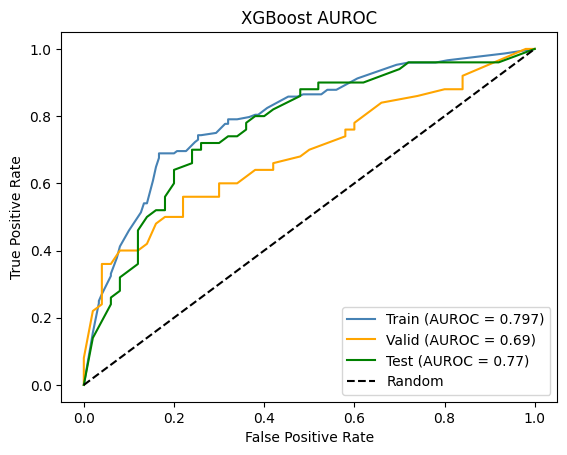

In [59]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = bay_classifier.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = bay_classifier.predict_proba(X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = bay_classifier.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

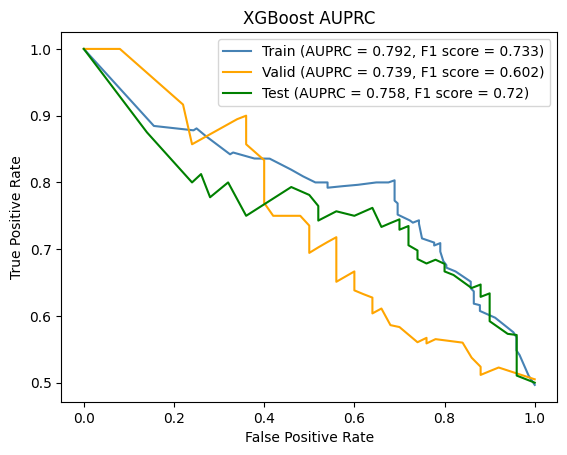

In [60]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()
y_pred = bay_classifier.predict_proba(X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = bay_classifier.predict_proba(X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = bay_classifier.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

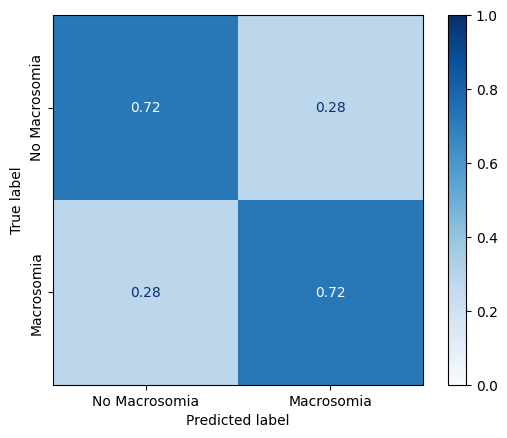

In [61]:
#plotting confusion matrix
predictions = bay_classifier.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=bay_classifier.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        bay_classifier,
        X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

weight:  {'AGE_AT_DELIVERY': 2.0, 'Term': 2.0, 'R_BMI': 5.0, 'GA_IN_DAYS': 4.0, 'Baby_Sex': 1.0}
gain:  {'AGE_AT_DELIVERY': 3.764798879623413, 'Term': 6.328554630279541, 'R_BMI': 8.408204078674316, 'GA_IN_DAYS': 2.9738025665283203, 'Baby_Sex': 2.9735982418060303}
cover:  {'AGE_AT_DELIVERY': 52.7681999206543, 'Term': 59.693363189697266, 'R_BMI': 57.62385177612305, 'GA_IN_DAYS': 22.77423858642578, 'Baby_Sex': 52.41635513305664}
total_gain:  {'AGE_AT_DELIVERY': 7.529597759246826, 'Term': 12.657109260559082, 'R_BMI': 42.041019439697266, 'GA_IN_DAYS': 11.895210266113281, 'Baby_Sex': 2.9735982418060303}
total_cover:  {'AGE_AT_DELIVERY': 105.5363998413086, 'Term': 119.38672637939453, 'R_BMI': 288.1192626953125, 'GA_IN_DAYS': 91.09695434570312, 'Baby_Sex': 52.41635513305664}


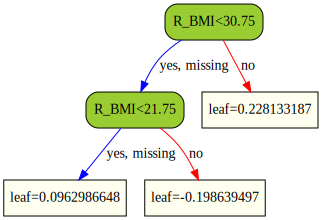

In [62]:
#plotting tree
bst = bay_classifier.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#9ACD32'     
                }  

leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#FFFFF0'     
                }  

xgb.to_graphviz(bay_classifier, num_trees=1, 
                size='10,10',
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

#add .render() at the end to save as pdf

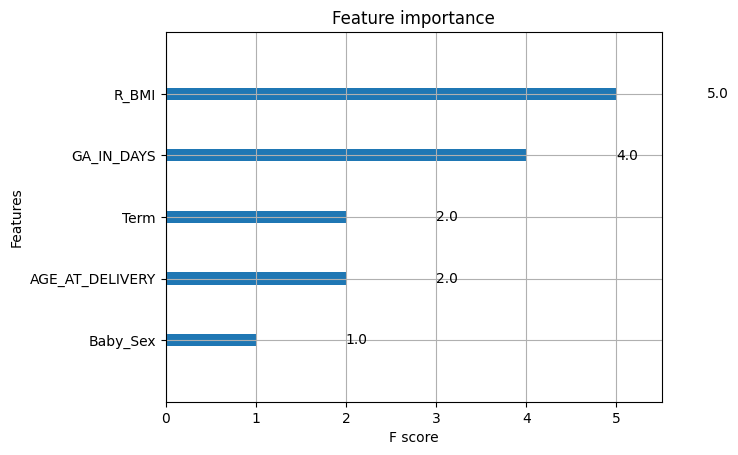

In [63]:
#plotting overall feature importance
plot_importance(bay_classifier)
plt.show()

In [64]:
#plotting individual feature importance
explainer = shap.Explainer(bay_classifier)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.initjs()
shap.plots.force(shap_values[0])

## Scenario 11:

### Imputation method: XGB Missing parameter (XGB MP)
### Class imbalance: No (No CI)
### Feature selection: Yes (FS)
### Optimization: Grid search (GS)

In [26]:
#selecting features

thresholds = sort(clf_xgb.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(clf_xgb, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier(scale_pos_weight = 1, missing = 0)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=33, Accuracy: 65.00%
Thresh=0.000, n=33, Accuracy: 65.00%
Thresh=0.000, n=33, Accuracy: 65.00%
Thresh=0.000, n=33, Accuracy: 65.00%
Thresh=0.000, n=33, Accuracy: 65.00%
Thresh=0.000, n=33, Accuracy: 65.00%
Thresh=0.000, n=33, Accuracy: 65.00%
Thresh=0.000, n=33, Accuracy: 65.00%
Thresh=0.000, n=33, Accuracy: 65.00%
Thresh=0.000, n=33, Accuracy: 65.00%
Thresh=0.000, n=33, Accuracy: 65.00%
Thresh=0.000, n=33, Accuracy: 65.00%
Thresh=0.000, n=33, Accuracy: 65.00%
Thresh=0.000, n=33, Accuracy: 65.00%
Thresh=0.000, n=33, Accuracy: 65.00%
Thresh=0.000, n=33, Accuracy: 65.00%
Thresh=0.000, n=33, Accuracy: 65.00%
Thresh=0.013, n=16, Accuracy: 65.00%
Thresh=0.036, n=15, Accuracy: 65.00%
Thresh=0.037, n=14, Accuracy: 64.00%
Thresh=0.045, n=13, Accuracy: 69.00%
Thresh=0.049, n=12, Accuracy: 65.00%
Thresh=0.053, n=11, Accuracy: 62.00%
Thresh=0.053, n=10, Accuracy: 65.00%
Thresh=0.054, n=9, Accuracy: 65.00%
Thresh=0.059, n=8, Accuracy: 66.00%
Thresh=0.060, n=7, Accuracy: 59.00%
Thre

In [27]:
#selecting and fitting model to threshold producing best accuracy

selection = SelectFromModel(clf_xgb, threshold=0.055, prefit=True)
select_X_train = selection.transform(X_train)

# train model
selection_model = XGBClassifier(scale_pos_weight = 1, missing = 0)
selection_model.fit(select_X_train, y_train)

# eval model
select_X_valid = selection.transform(X_valid)
select_X_test = selection.transform(X_test)

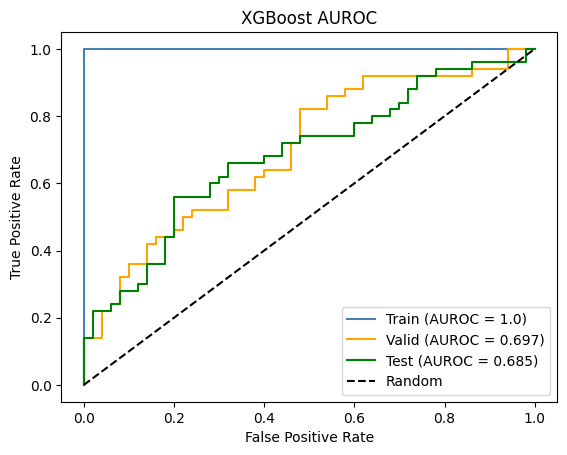

In [28]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = selection_model.predict_proba(select_X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = selection_model.predict_proba(select_X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = selection_model.predict_proba(select_X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

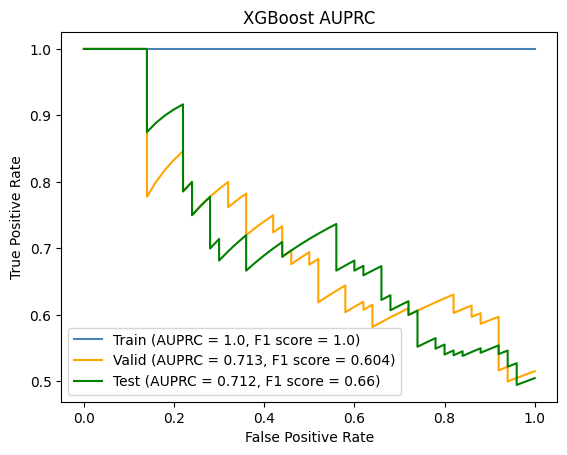

In [29]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = selection_model.predict_proba(select_X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = selection_model.predict_proba(select_X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = selection_model.predict_proba(select_X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

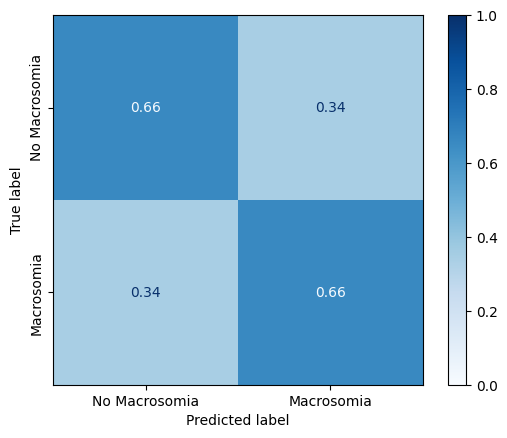

In [30]:
#plotting confusion matrix
predictions = selection_model.predict(select_X_test)
cm = confusion_matrix(y_test, predictions, labels=selection_model.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        selection_model,
        select_X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

In [31]:
# #optimizating using Grid Search

# #ROUND 1

# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.5, 1],
#     'reg_lambda': [0, 5, 10], 
#     'n_estimators': [50, 70, 90],
#     'min_child_weight': [5, 6, 7]
# }

In [32]:
# #ROUND 2

# param_grid = {
#     'max_depth': [1, 2, 3],
#     'learning_rate': [0.1, 0.2, 0.3],
#     'gamma': [0],
#     'reg_lambda': [10, 11, 12], 
#     'n_estimators': [70],
#     'min_child_weight': [7, 8, 9]
# }

In [79]:
#ROUND 3

param_grid = {
    'max_depth': [0, 0.5, 1],
    'learning_rate': [0.3, 0.4, 0.5],
    'gamma': [0],
    'reg_lambda': [10], 
    'n_estimators': [70],
    'min_child_weight': [9, 10, 11]
}

In [80]:
#grid searching for best hyperparameters
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5,
                                scale_pos_weight = 1,
                                missing = 0),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=2,
    n_jobs = 10,
    cv = 5
)

In [81]:
#printing optimal parameters to readjust for actual training
optimal_params.fit(select_X_train, 
                  y_train,
                  early_stopping_rounds=10,
                  eval_metric='auc',
                  eval_set=[(select_X_valid, y_valid)],
                  verbose=False)
print(optimal_params.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'gamma': 0, 'learning_rate': 0.3, 'max_depth': 1, 'min_child_weight': 9, 'n_estimators': 70, 'reg_lambda': 10}


In [33]:
#fitting model to tuned hyperparameters
selection_model = xgb.XGBClassifier(objective='binary:logistic', 
                            seed=42,
                            gamma=0,
                            learning_rate=0.3,
                            max_depth=1,
                            min_child_weight = 9,
                            n_estimators = 70,
                            reg_lambda=10,
                            scale_pos_weight=1, #sum(negative instances) / sum(positive instances)d
                            subsample=0.9,
                            colsample_bytree=0.5,
                            missing = 0)

selection_model.fit(select_X_train,
           y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='auc',
           eval_set=[(select_X_train, y_train), (select_X_valid, y_valid), (select_X_test, y_test)])

[0]	validation_0-auc:0.62446	validation_1-auc:0.66000	validation_2-auc:0.61000
[1]	validation_0-auc:0.65973	validation_1-auc:0.69440	validation_2-auc:0.65240
[2]	validation_0-auc:0.74723	validation_1-auc:0.72560	validation_2-auc:0.76820
[3]	validation_0-auc:0.73831	validation_1-auc:0.73580	validation_2-auc:0.74260
[4]	validation_0-auc:0.75827	validation_1-auc:0.74700	validation_2-auc:0.77360
[5]	validation_0-auc:0.75583	validation_1-auc:0.72860	validation_2-auc:0.77520
[6]	validation_0-auc:0.75784	validation_1-auc:0.73360	validation_2-auc:0.76800
[7]	validation_0-auc:0.76133	validation_1-auc:0.74940	validation_2-auc:0.76980
[8]	validation_0-auc:0.76282	validation_1-auc:0.75440	validation_2-auc:0.76720
[9]	validation_0-auc:0.77218	validation_1-auc:0.75540	validation_2-auc:0.77160
[10]	validation_0-auc:0.77484	validation_1-auc:0.74460	validation_2-auc:0.77680
[11]	validation_0-auc:0.77441	validation_1-auc:0.74000	validation_2-auc:0.77880
[12]	validation_0-auc:0.77437	validation_1-auc:0.7

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=9,
              missing=0, monotone_constraints='()', n_estimators=70, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=10, ...)

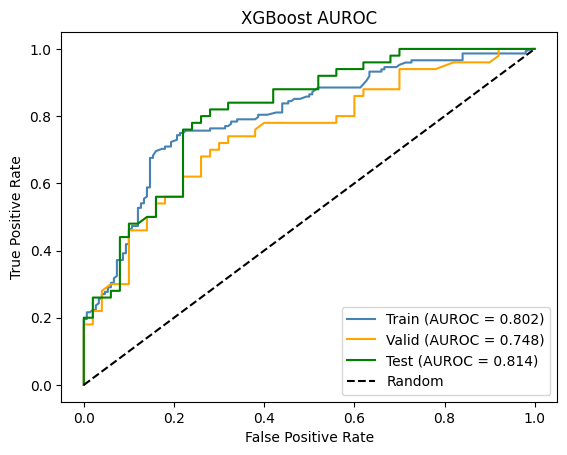

In [34]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = selection_model.predict_proba(select_X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = selection_model.predict_proba(select_X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = selection_model.predict_proba(select_X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

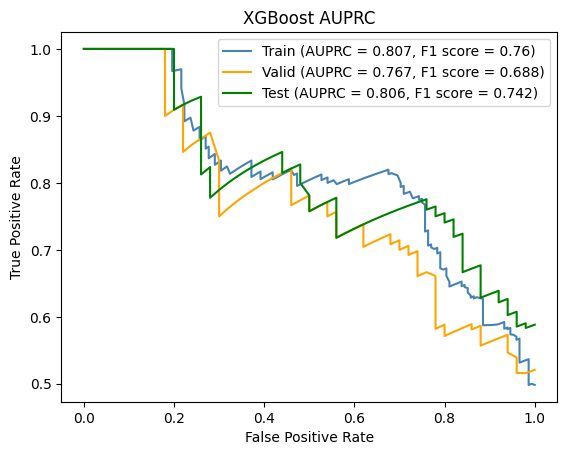

In [35]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = selection_model.predict_proba(select_X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = selection_model.predict_proba(select_X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = selection_model.predict_proba(select_X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

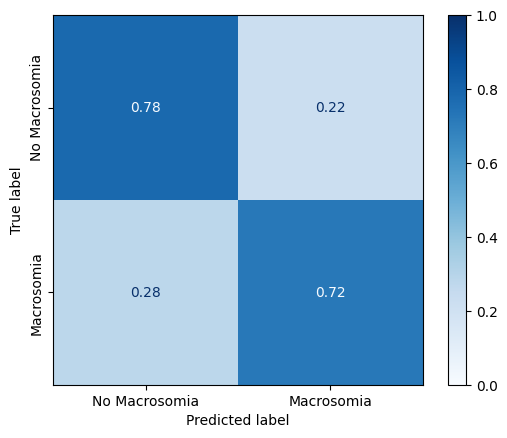

In [36]:
#plotting confusion matrix
predictions = selection_model.predict(select_X_test)
cm = confusion_matrix(y_test, predictions, labels=selection_model.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        selection_model,
        select_X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

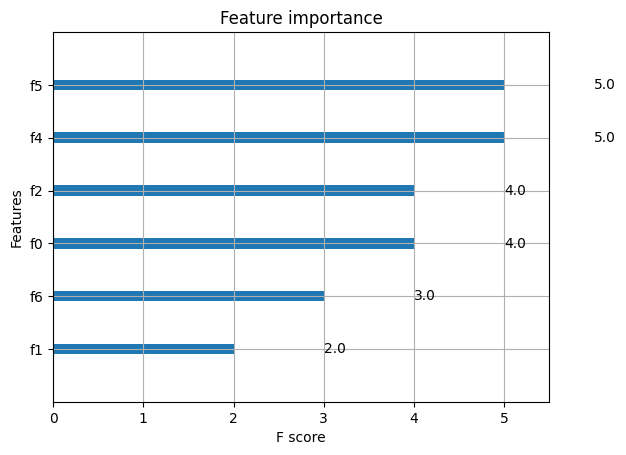

In [86]:
#plotting overall feature importance
plot_importance(selection_model)
plt.show()

In [39]:
#checking accuracy difference before and after optimization
from sklearn.metrics import accuracy_score

predictions_1 = clf_xgb.predict(X_test)
accuracy = accuracy_score(y_test, predictions_1)
print("Accuracy before optimization: %.2f%%" % (accuracy * 100.0))

accuracy = accuracy_score(y_test, predictions)
print("Accuracy after optimization: %.2f%%" % (accuracy * 100.0))

Accuracy before optimization: 61.00%
Accuracy after optimization: 75.00%


In [87]:
#plotting individual feature importance
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.force(shap_values[1])

## Scenario 12:

### Imputation method: XGB Missing parameter (XGB MP)
### Class imbalance: No (No CI)
### Feature selection: Yes (FS)
### Optimization: Bayesian (Bay.)

In [88]:
#Converting the dataframe into XGBoost’s Dmatrix object
dtrain = xgb.DMatrix(select_X_train, label=y_train)

#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, n_estimators, learning_rate, reg_lambda, min_child_weight):
    params = {'max_depth': int(max_depth),
              'learning_rate':learning_rate,
              'gamma': gamma,
              'reg_lambda': reg_lambda,
              'n_estimators': int(n_estimators),
              'min_child_weight': min_child_weight,
              'subsample': 0.9,
              'eta': 0.1,
              
              'eval_metric': 'rmse'}
    #Cross validating with the specified parameters in 5 folds and 70 iterations
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                            'learning_rate': (0, 1),
                                            'gamma': (0, 5),
                                            'reg_lambda': (3, 20), 
                                            'n_estimators': (50, 350),
                                            'min_child_weight': (1, 10)
                                            }, random_state = 42)

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_la... |
-------------------------------------------------------------------------------------------------
[05:30:20] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:30:20] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:30:20] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } mig

|  5        | -0.4777   |  2.28     |  0.7852   |  4.398    |  5.628    |  227.7    |  3.79     |
[05:30:37] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:30:37] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:30:37] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

|  10       | -0.4882   |  5.0      |  0.2583   |  6.891    |  1.0      |  137.0    |  9.579    |
[05:30:55] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:30:55] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:30:55] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

In [89]:
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

#Initialize an XGBClassifier with the tuned parameters and fit the training data
from xgboost import XGBClassifier
bay_classifier = XGBClassifier(**params).fit(select_X_train, y_train)

#predicting for training set
train_p2 = bay_classifier.predict(select_X_valid)

#Looking at the classification report
print(classification_report(train_p2, y_valid))

{'gamma': 1.5176148549762425, 'learning_rate': 0.6254232116714128, 'max_depth': 7.779089841219697, 'min_child_weight': 4.320298026380028, 'n_estimators': 85.61108965218878, 'reg_lambda': 12.40355838813955}
              precision    recall  f1-score   support

           0       0.72      0.60      0.65        60
           1       0.52      0.65      0.58        40

    accuracy                           0.62       100
   macro avg       0.62      0.62      0.62       100
weighted avg       0.64      0.62      0.62       100



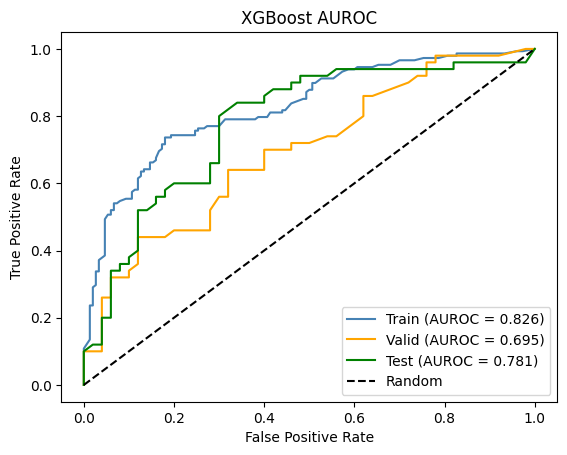

In [90]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = bay_classifier.predict_proba(select_X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = bay_classifier.predict_proba(select_X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = bay_classifier.predict_proba(select_X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

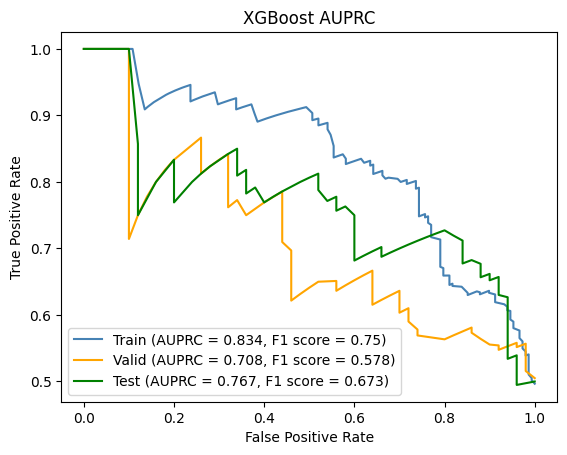

In [91]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()
y_pred = bay_classifier.predict_proba(select_X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = bay_classifier.predict_proba(select_X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = bay_classifier.predict_proba(select_X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

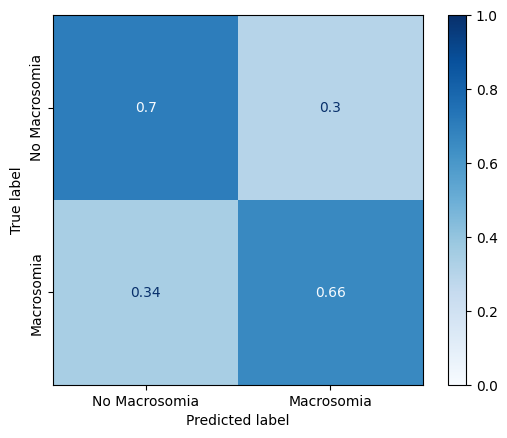

In [92]:
#plotting confusion matrix
predictions = bay_classifier.predict(select_X_test)
cm = confusion_matrix(y_test, predictions, labels=bay_classifier.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        bay_classifier,
        select_X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

weight:  {'f0': 4.0, 'f1': 1.0, 'f2': 2.0, 'f3': 1.0, 'f4': 9.0, 'f5': 8.0, 'f6': 1.0}
gain:  {'f0': 2.142019748687744, 'f1': 2.0241546630859375, 'f2': 5.844417572021484, 'f3': 1.8976798057556152, 'f4': 5.196342468261719, 'f5': 2.1809208393096924, 'f6': 2.2110648155212402}
cover:  {'f0': 46.44378662109375, 'f1': 26.769214630126953, 'f2': 59.61345672607422, 'f3': 22.20163345336914, 'f4': 54.11105728149414, 'f5': 33.647369384765625, 'f6': 45.76240539550781}
total_gain:  {'f0': 8.568078994750977, 'f1': 2.0241546630859375, 'f2': 11.688835144042969, 'f3': 1.8976798057556152, 'f4': 46.76708221435547, 'f5': 17.44736671447754, 'f6': 2.2110648155212402}
total_cover:  {'f0': 185.775146484375, 'f1': 26.769214630126953, 'f2': 119.22691345214844, 'f3': 22.20163345336914, 'f4': 486.99951171875, 'f5': 269.178955078125, 'f6': 45.76240539550781}


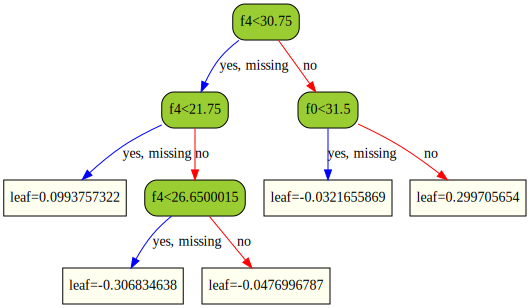

In [93]:
#plotting tree
bst = bay_classifier.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#9ACD32'     
                }  

leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#FFFFF0'     
                }  

xgb.to_graphviz(bay_classifier, num_trees=1, 
                size='10,10',
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

#add .render() at the end to save as pdf

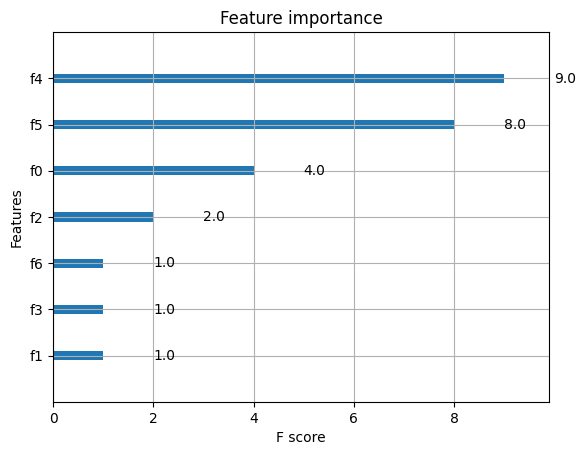

In [94]:
#plotting overall feature importance
plot_importance(bay_classifier)
plt.show()

In [95]:
#plotting individual feature importance
explainer = shap.Explainer(bay_classifier)
shap_values = explainer(select_X_test)

# visualize the first prediction's explanation
shap.initjs()
shap.plots.force(shap_values[0])